In [1]:
import numpy as np
import scipy as ci 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML

import seaborn as sns 
import tables 
import pickle
import warnings
warnings.filterwarnings('once')

%matplotlib inline 

In [2]:
lifetime = 86400*365 # 1 year! 
fig_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/plots/ana-2-'

In [3]:
# ineff model parameters 
params = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/IT_model.txt')
def ineff_model(dist,E): # E: log10 of energy!!! 

    a = params[0] + params[2] * (E + params[1])**2
    b = params[3] + params[5] * (E + params[4])**2
    val = 10 * a / dist**(1/3.) * np.exp( -10**6 * b / dist**2)
    
    val[val < 1e-5] = 1e-5 # This is arbitrary! 

    # low stat cut 
    val[E > 5.4+1.9*np.sqrt(1 - (dist)**2/2300**2)]=0.7
    val[dist>2200]=0.7
    return val

# data/MC

In [20]:
IT_ineff_cut = 0.01
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/corsika_h5/corsika_11937.h5','r') as f:
    n_file = 99932 # with _rf, the size of broken file is 266K instead of 0! 

    ineff_ = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_ < IT_ineff_cut
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18

    CUT = CUT_ineff & CUT_dedx & CUT_cascllh     
    
    chi2_corsika = f.root.Collection.cols.chi2[:][CUT]
    chi2_red_corsika =  f.root.Collection.cols.chi2_red[:][CUT]
    PeakOverMedian_corsika = f.root.Collection.cols.PeakOverMedian[:][CUT]
    stoch_corsika = (chi2_red_corsika + (np.log10(PeakOverMedian_corsika)/2))/np.sqrt(2)
    zenith_corsika = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_corsika = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_corsika = f.root.Collection.cols.len_dEdxVector[:][CUT]
    closest_d_corsika = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    cascllh_corsika = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    bsize_corsika = f.root.Bundle.cols.Size[:][CUT]
    coincident_corsika = f.root.MCPrimary_coincident.cols.value[:][CUT]
    prim_e_corsika = f.root.MCPrimary_new.cols.energy[:][CUT]
    NPE_corsika = f.root.QTot.cols.value[:][CUT]
#     IT_ineff_corsika = ineff_[CUT]
    
    # muon bundle 
    bsize_corsika = f.root.Bundle.cols.Size[:][CUT]
    Ec_bundle_e_corsika = f.root.Bundle.cols.MuonBundleEnergy[:][CUT]
    Ec_most_energetic_corsika = f.root.Bundle.cols.MostEnergeticMuonEnergy[:][CUT]
    Ei_most_energetic_corsika = f.root.Bundle.cols.MostEnergeticMuonEnergy_i[:][CUT]
    Esurf_most_energetic_corsika = f.root.Bundle.cols.MostEnergeticMuonEnergyAtSurface[:][CUT]
    singleness_corsika = f.root.Bundle.cols.Singleness[:][CUT]
    xf_corsika = Ec_bundle_e_corsika/prim_e_corsika
    
    CUT_PPlus = f.root.MCPrimary_new.cols.type[:][CUT] == 2212
    CUT_He = f.root.MCPrimary_new.cols.type[:][CUT] == 1000020040
    CUT_N= f.root.MCPrimary_new.cols.type[:][CUT] == 1000070140
    CUT_Al = f.root.MCPrimary_new.cols.type[:][CUT] == 1000130270
    CUT_Fe = f.root.MCPrimary_new.cols.type[:][CUT] == 1000260560
    
    runid_corsika = f.root.FileNumber.cols.value[:][CUT]
    eventid_corsika = f.root.FileNumber.cols.Event[:][CUT]
    
    weight_corsika = f.root.Weight_GaisserH3a.cols.value[:][CUT] * lifetime/n_file # * 903098/363528
    

with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/nugen_h5/nugen_11374.h5','r') as f:
    n_file = 19999

    ineff_ = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_ < IT_ineff_cut
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18

    CUT = CUT_ineff & CUT_dedx & CUT_cascllh    

    chi2_numu = f.root.Collection.cols.chi2[:][CUT]
    chi2_red_numu =  f.root.Collection.cols.chi2_red[:][CUT]
    PeakOverMedian_numu = f.root.Collection.cols.PeakOverMedian[:][CUT]
    stoch_numu = (chi2_red_numu + (np.log10(PeakOverMedian_numu)/2))/np.sqrt(2)
    zenith_numu = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_numu = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_numu = f.root.Collection.cols.len_dEdxVector[:][CUT]
    closest_d_numu = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    cascllh_numu = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    bsize_numu = f.root.Bundle.cols.Size[:][CUT]
    coincident_numu = f.root.MCPrimary_coincident.cols.value[:][CUT]
    prim_e_numu = f.root.MCPrimary_new.cols.energy[:][CUT]
    NPE_numu = f.root.QTot.cols.value[:][CUT]
    ### astrophysical ###
    energy = f.root.MCPrimary_new.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_numu_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar
    
with tables.open_file('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/data_h5/data_burn.h5','r') as f:
    nfile_data = [2831731.134,3081951.304,3110722.657,3155703.188,3082765.564]
    
    ineff_ = ineff_model(f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))
    CUT_ineff = ineff_ < IT_ineff_cut
    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18

    CUT = CUT_ineff & CUT_dedx & CUT_cascllh  
    
    chi2_red_data_burn = f.root.Collection.cols.chi2_red[:][CUT]
    PeakOverMedian_data_burn = f.root.Collection.cols.PeakOverMedian[:][CUT]
    stoch_data_burn = (chi2_red_data_burn + (np.log10(PeakOverMedian_data_burn)/2))/np.sqrt(2)
    zenith_data_burn = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_data_burn = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_data_burn = f.root.Collection.cols.len_dEdxVector[:][CUT]
    IT_Npulse_data_burn = f.root.IT_veto_double.cols.num_Total_hits[:][CUT]
    closest_d_data_burn = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    Npulse_in_window_data_burn = f.root.IT_veto_double.cols.num_correlated_Total_hits_in_window[:][CUT]
    Npulse_off_window_data_burn = f.root.IT_veto_double.cols.num_correlated_Total_hits_off_window[:][CUT]
    cascllh_data_burn = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    NPE_data_burn = f.root.QTot.cols.value[:][CUT]
    
    weight_data_burn = lifetime/np.sum(nfile_data) * np.ones(len(zenith_data_burn))
    
    run_id_data_burn = f.root.I3EventHeader.cols.Run[:][CUT]
    event_id_data_burn = f.root.I3EventHeader.cols.Event[:][CUT]
    

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


In [21]:
print(np.sum(weight_corsika))
print(np.sum(weight_numu_astro))
print(np.sum(weight_data_burn))

205573.23947055955
1.6244313638405177
178128.32126201343


In [10]:
plt.rcParams.update({'font.size': 19})

def sumw2(h,b,weight,quantity):
    w_2 = []
    for i in range(0,len(b)-1):
        all_weight_in_bin = weight[(b[i]<quantity)&(quantity<b[i+1])]
        w_2.append(np.sum(all_weight_in_bin**2))
    return w_2

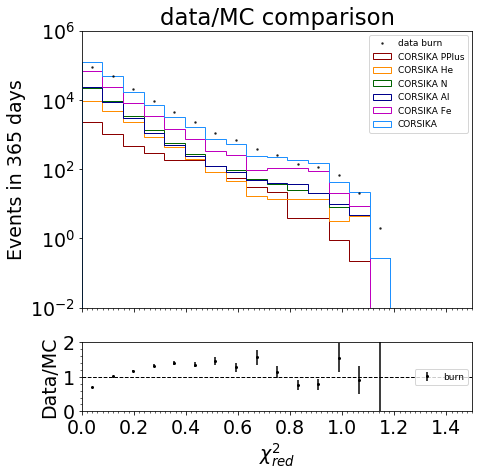

In [11]:
# chi2_red 

plt.figure(figsize=(7,7))

gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax1 = plt.subplot(gs[0])

# h_a,b_a,p_a = plt.hist(chi2_red_corsika,bins=np.arange(0,1.5,0.02),log=True,histtype='step',lw=1,label='CORSIKA adjusted',weights=weight_corsika_adjusted,bottom=10**(-6),color='red')

plt.hist(chi2_red_corsika[CUT_PPlus],bins=np.linspace(0,1.5,20),log=True,histtype='step',lw=1,label='CORSIKA PPlus',weights=weight_corsika[CUT_PPlus],bottom=10**(-6),color='darkred')
plt.hist(chi2_red_corsika[CUT_He],bins=np.linspace(0,1.5,20),log=True,histtype='step',lw=1,label='CORSIKA He',weights=weight_corsika[CUT_He],bottom=10**(-6),color='darkorange')
plt.hist(chi2_red_corsika[CUT_N],bins=np.linspace(0,1.5,20),log=True,histtype='step',lw=1,label='CORSIKA N',weights=weight_corsika[CUT_N],bottom=10**(-6),color='darkgreen')
plt.hist(chi2_red_corsika[CUT_Al],bins=np.linspace(0,1.5,20),log=True,histtype='step',lw=1,label='CORSIKA Al',weights=weight_corsika[CUT_Al],bottom=10**(-6),color='darkblue')
plt.hist(chi2_red_corsika[CUT_Fe],bins=np.linspace(0,1.5,20),log=True,histtype='step',lw=1,label='CORSIKA Fe',weights=weight_corsika[CUT_Fe],bottom=10**(-6),color='m')
h,b,p = plt.hist(chi2_red_corsika,bins=np.linspace(0,1.5,20),log=True,histtype='step',lw=1,label='CORSIKA',weights=weight_corsika,bottom=10**(-6),color='dodgerblue')

hh,bb = np.histogram(chi2_red_data_burn,bins=np.linspace(0,1.5,20),weights = weight_data_burn)
plt.plot((bb[1:]+bb[:-1])/2,hh,'.',ms=3,alpha=0.7,label='data burn',color='black')

plt.ylabel('Events in 365 days')
plt.xlim(0,1.5)
plt.ylim(10**(-2),10**6)
plt.legend(loc='best',prop={'size': 9})
plt.title('data/MC comparison')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
ax1.tick_params(labelbottom=False)    

ax2 = plt.subplot(gs[1])

err_w = np.sqrt(sumw2(h,b,weight_corsika,chi2_red_corsika))
err_ww = np.sqrt(sumw2(hh,bb,weight_data_burn,chi2_red_data_burn))

h = h[hh > 0.]
bb = ((bb[1:]+bb[:-1])/2)[hh > 0.]
err_w = err_w[hh>0.]
err_ww = err_ww[hh>0.]
hh = hh[hh > 0.]
yerr = np.sqrt(err_ww**2/h**2 + hh**2/h**4*err_w**2)
plt.errorbar(bb, hh/h, yerr = yerr, fmt='.',ms=4,color='black',label='burn')

plt.axhline(1,ls='--',lw=1,color='black')

plt.xlabel(r'$\chi^2_{red}$')
plt.ylabel('Data/MC')
plt.legend(loc='right',prop={'size': 9})
plt.xlim(0,1.5)
plt.ylim(0,2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(1.))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))

plt.savefig(fig_dir+'hist1d_chi2_red_data_MC.png',bbox_inches='tight',dpi=300)
plt.savefig(fig_dir+'hist1d_chi2_red_data_MC.pdf',bbox_inches='tight')

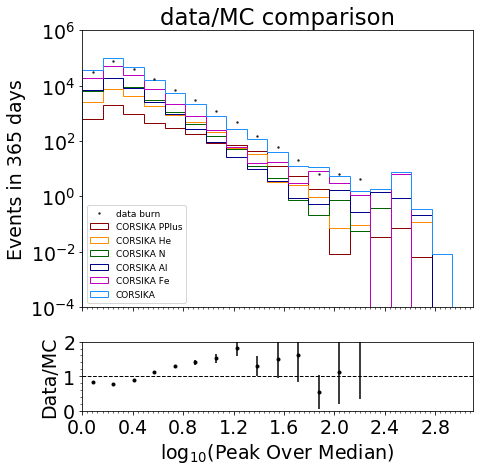

In [12]:
plt.figure(figsize=(7,7))

gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax1 = plt.subplot(gs[0])

plt.hist(np.log10(PeakOverMedian_corsika[CUT_PPlus]),bins=np.linspace(0,3.1,20),log=True,histtype='step',lw=1,label='CORSIKA PPlus',weights=weight_corsika[CUT_PPlus],bottom=10**(-6),color='darkred')
plt.hist(np.log10(PeakOverMedian_corsika[CUT_He]),bins=np.linspace(0,3.1,20),log=True,histtype='step',lw=1,label='CORSIKA He',weights=weight_corsika[CUT_He],bottom=10**(-6),color='darkorange')
plt.hist(np.log10(PeakOverMedian_corsika[CUT_N]),bins=np.linspace(0,3.1,20),log=True,histtype='step',lw=1,label='CORSIKA N',weights=weight_corsika[CUT_N],bottom=10**(-6),color='darkgreen')
plt.hist(np.log10(PeakOverMedian_corsika[CUT_Al]),bins=np.linspace(0,3.1,20),log=True,histtype='step',lw=1,label='CORSIKA Al',weights=weight_corsika[CUT_Al],bottom=10**(-6),color='darkblue')
plt.hist(np.log10(PeakOverMedian_corsika[CUT_Fe]),bins=np.linspace(0,3.1,20),log=True,histtype='step',lw=1,label='CORSIKA Fe',weights=weight_corsika[CUT_Fe],bottom=10**(-6),color='m')
h,b,p = plt.hist(np.log10(PeakOverMedian_corsika),bins=np.linspace(0,3.1,20),log=True,histtype='step',lw=1,label='CORSIKA',weights=weight_corsika,bottom=10**(-6),color='dodgerblue')
hh,bb = np.histogram(np.log10(PeakOverMedian_data_burn),bins=np.linspace(0,3.1,20),weights = weight_data_burn)
plt.plot((bb[1:]+bb[:-1])/2,hh,'.',ms=3,alpha=0.7,label='data burn',color='black')

plt.ylabel('Events in 365 days')
plt.xlim(0,3.1)
plt.ylim(10**(-4),10**6)
plt.legend(loc='lower left',prop={'size': 9})
plt.title('data/MC comparison')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.4))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
ax1.tick_params(labelbottom=False)    

ax2 = plt.subplot(gs[1])
err_w = np.sqrt(sumw2(h,b,weight_corsika,np.log10(PeakOverMedian_corsika)))
err_ww = np.sqrt(sumw2(hh,bb,weight_data_burn,np.log10(PeakOverMedian_data_burn)))

h = h[hh > 0.]
bb = ((bb[1:]+bb[:-1])/2)[hh > 0.]
err_w = err_w[hh>0.]
err_ww = err_ww[hh>0.]
hh = hh[hh > 0.]
yerr = np.sqrt(err_ww**2/h**2 + hh**2/h**4*err_w**2)
plt.errorbar(bb, hh/h, yerr = yerr, fmt='.',color='black')
plt.axhline(1,ls='--',lw=1,color='black')

plt.xlabel(r'$\log_{10}$(Peak Over Median)')
plt.ylabel('Data/MC')
plt.xlim(0,3.1)
plt.ylim(0,2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.4))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.04))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(1.))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))

plt.savefig(fig_dir+'hist1d_PeakOverMedian_data_MC.png',bbox_inches='tight',dpi=300)
plt.savefig(fig_dir+'hist1d_PeakOverMedian_data_MC.pdf',bbox_inches='tight')

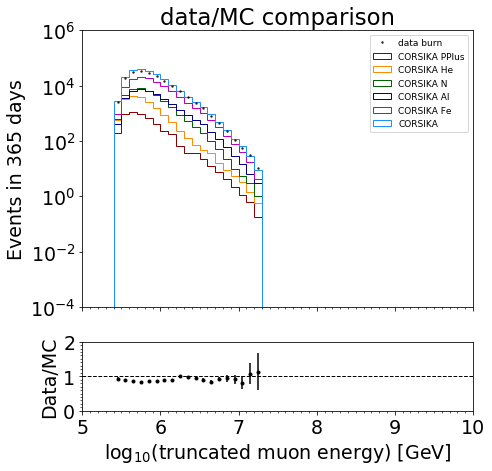

In [13]:
# truncated 
plt.figure(figsize=(7,7))

gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax1 = plt.subplot(gs[0])

plt.hist(np.log10(truncated_muon_e_corsika[CUT_PPlus]),bins=np.arange(5,12.1,0.1),log=True,histtype='step',lw=1,label='CORSIKA PPlus',weights=weight_corsika[CUT_PPlus],bottom=10**(-6),color='darkred')
plt.hist(np.log10(truncated_muon_e_corsika[CUT_He]),bins=np.arange(5,12.1,0.1),log=True,histtype='step',lw=1,label='CORSIKA He',weights=weight_corsika[CUT_He],bottom=10**(-6),color='darkorange')
plt.hist(np.log10(truncated_muon_e_corsika[CUT_N]),bins=np.arange(5,12.1,0.1),log=True,histtype='step',lw=1,label='CORSIKA N',weights=weight_corsika[CUT_N],bottom=10**(-6),color='darkgreen')
plt.hist(np.log10(truncated_muon_e_corsika[CUT_Al]),bins=np.arange(5,12.1,0.1),log=True,histtype='step',lw=1,label='CORSIKA Al',weights=weight_corsika[CUT_Al],bottom=10**(-6),color='darkblue')
plt.hist(np.log10(truncated_muon_e_corsika[CUT_Fe]),bins=np.arange(5,12.1,0.1),log=True,histtype='step',lw=1,label='CORSIKA Fe',weights=weight_corsika[CUT_Fe],bottom=10**(-6),color='m')
h,b,p = plt.hist(np.log10(truncated_muon_e_corsika),bins=np.arange(5,12.1,0.1),log=True,histtype='step',lw=1,label='CORSIKA',weights=weight_corsika,bottom=10**(-6),color='dodgerblue')
hh,bb = np.histogram(np.log10(truncated_muon_e_data_burn),bins=np.arange(5,12.1,0.1),weights = weight_data_burn)
plt.plot((bb[1:]+bb[:-1])/2,hh,'.',ms=3,alpha=0.7,label='data burn',color='black')

plt.ylabel('Events in 365 days')
plt.xlim(5,10)
plt.ylim(10**(-4),10**6)
plt.legend(prop={'size': 9})
plt.title('data/MC comparison')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax1.tick_params(labelbottom=False)    

ax2 = plt.subplot(gs[1])
err_w = np.sqrt(sumw2(h,b,weight_corsika,np.log10(truncated_muon_e_corsika)))
err_ww = np.sqrt(sumw2(hh,bb,weight_data_burn,np.log10(truncated_muon_e_data_burn)))

h = h[hh > 0.]
bb = ((bb[1:]+bb[:-1])/2)[hh > 0.]
err_w = err_w[hh>0.]
err_ww = err_ww[hh>0.]
hh = hh[hh > 0.]
yerr = np.sqrt(err_ww**2/h**2 + hh**2/h**4*err_w**2)
plt.errorbar(bb, hh/h, yerr = yerr, fmt='.',color='black')
plt.axhline(1,ls='--',lw=1,color='black')

plt.xlabel(r'$\log_{10}($truncated muon energy) [GeV]')
plt.ylabel('Data/MC')
plt.xlim(5,10)
plt.ylim(0,2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(1.))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

plt.savefig(fig_dir+'hist1d_truncated_data_MC.png',bbox_inches='tight',dpi=300)
plt.savefig(fig_dir+'hist1d_truncated_data_MC.pdf',bbox_inches='tight')

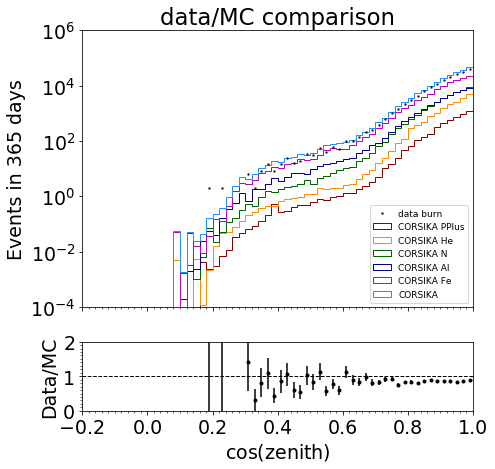

In [14]:
# cos(zenith)

plt.figure(figsize=(7,7))

gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax1 = plt.subplot(gs[0])


plt.hist(np.cos(zenith_corsika[CUT_PPlus]),bins=np.arange(-0.2,1.1,0.02),log=True,histtype='step',lw=1,label='CORSIKA PPlus',weights=weight_corsika[CUT_PPlus],bottom=10**(-6),color='darkred')
plt.hist(np.cos(zenith_corsika[CUT_He]),bins=np.arange(-0.2,1.1,0.02),log=True,histtype='step',lw=1,label='CORSIKA He',weights=weight_corsika[CUT_He],bottom=10**(-6),color='darkorange')
plt.hist(np.cos(zenith_corsika[CUT_N]),bins=np.arange(-0.2,1.1,0.02),log=True,histtype='step',lw=1,label='CORSIKA N',weights=weight_corsika[CUT_N],bottom=10**(-6),color='darkgreen')
plt.hist(np.cos(zenith_corsika[CUT_Al]),bins=np.arange(-0.2,1.1,0.02),log=True,histtype='step',lw=1,label='CORSIKA Al',weights=weight_corsika[CUT_Al],bottom=10**(-6),color='darkblue')
plt.hist(np.cos(zenith_corsika[CUT_Fe]),bins=np.arange(-0.2,1.1,0.02),log=True,histtype='step',lw=1,label='CORSIKA Fe',weights=weight_corsika[CUT_Fe],bottom=10**(-6),color='m')
h,b,p = plt.hist(np.cos(zenith_corsika),bins=np.arange(-0.2,1.1,0.02),log=True,histtype='step',lw=1,label='CORSIKA',weights=weight_corsika,bottom=10**(-6),color='dodgerblue')
hh,bb = np.histogram(np.cos(zenith_data_burn),bins=np.arange(-0.2,1.1,0.02),weights = weight_data_burn)
plt.plot((bb[1:]+bb[:-1])/2,hh,'.',ms=3,alpha=0.7,label='data burn',color='black')

plt.ylabel('Events in 365 days')
plt.xlim(-0.2,1)
plt.ylim(10**(-4),10**6)
plt.legend(prop={'size': 9},loc='lower right')
plt.title('data/MC comparison')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
ax1.tick_params(labelbottom=False)   

ax2 = plt.subplot(gs[1])
err_w = np.sqrt(sumw2(h,b,weight_corsika,np.cos(zenith_corsika)))
err_ww = np.sqrt(sumw2(hh,bb,weight_data_burn,np.cos(zenith_data_burn)))

h = h[hh > 0.]
bb = ((bb[1:]+bb[:-1])/2)[hh > 0.]
err_w = err_w[hh>0.]
err_ww = err_ww[hh>0.]
hh = hh[hh > 0.]
yerr = np.sqrt(err_ww**2/h**2 + hh**2/h**4*err_w**2)
plt.errorbar(bb, hh/h, yerr = yerr, fmt='.',color='black')
plt.axhline(1,ls='--',lw=1,color='black')

plt.xlabel(r'$\cos$(zenith)')
plt.ylabel('Data/MC')
plt.xlim(-0.2,1)
plt.ylim(0,2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(1.))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

plt.savefig(fig_dir+'hist1d_zenith_data_MC.png',bbox_inches='tight',dpi=300)
plt.savefig(fig_dir+'hist1d_zenith_data_MC.pdf',bbox_inches='tight')

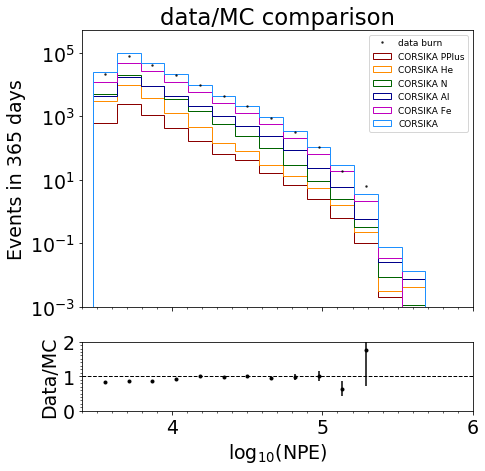

In [15]:
plt.figure(figsize=(7,7))

gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax1 = plt.subplot(gs[0])

# plt.hist(np.log10(NPE_corsika),bins=np.arange(3,7,0.04),log=True,histtype='step',lw=1,label='CORSIKA adjusted flux',weights=weight_corsika_adjusted,bottom=10**(-6),color='red')

plt.hist(np.log10(NPE_corsika[CUT_PPlus]),bins=np.linspace(3,6,20),log=True,histtype='step',lw=1,label='CORSIKA PPlus',weights=weight_corsika[CUT_PPlus],bottom=10**(-6),color='darkred')
plt.hist(np.log10(NPE_corsika[CUT_He]),bins=np.linspace(3,6,20),log=True,histtype='step',lw=1,label='CORSIKA He',weights=weight_corsika[CUT_He],bottom=10**(-6),color='darkorange')
plt.hist(np.log10(NPE_corsika[CUT_N]),bins=np.linspace(3,6,20),log=True,histtype='step',lw=1,label='CORSIKA N',weights=weight_corsika[CUT_N],bottom=10**(-6),color='darkgreen')
plt.hist(np.log10(NPE_corsika[CUT_Al]),bins=np.linspace(3,6,20),log=True,histtype='step',lw=1,label='CORSIKA Al',weights=weight_corsika[CUT_Al],bottom=10**(-6),color='darkblue')
plt.hist(np.log10(NPE_corsika[CUT_Fe]),bins=np.linspace(3,6,20),log=True,histtype='step',lw=1,label='CORSIKA Fe',weights=weight_corsika[CUT_Fe],bottom=10**(-6),color='m')
h,b,p = plt.hist(np.log10(NPE_corsika),bins=np.linspace(3,6,20),log=True,histtype='step',lw=1,label='CORSIKA',weights=weight_corsika,bottom=10**(-6),color='dodgerblue')
hh,bb = np.histogram(np.log10(NPE_data_burn),bins=np.linspace(3,6,20),weights = weight_data_burn)
plt.plot((bb[1:]+bb[:-1])/2,hh,'.',ms=3,alpha=0.7,label='data burn',color='black')

plt.ylabel('Events in 365 days')
plt.xlim(3.4,6)
plt.ylim(10**(-3),10**5.7)
plt.legend(prop={'size': 9})
plt.title('data/MC comparison')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax1.tick_params(labelbottom=False)    

ax2 = plt.subplot(gs[1])
err_w = np.sqrt(sumw2(h,b,weight_corsika,np.log10(NPE_corsika)))
err_ww = np.sqrt(sumw2(hh,bb,weight_data_burn,np.log10(NPE_data_burn)))

h = h[hh > 0.]
bb = ((bb[1:]+bb[:-1])/2)[hh > 0.]
err_w = err_w[hh>0.]
err_ww = err_ww[hh>0.]
hh = hh[hh > 0.]
yerr = np.sqrt(err_ww**2/h**2 + hh**2/h**4*err_w**2)
plt.errorbar(bb, hh/h, yerr = yerr, fmt='.',color='black')
plt.axhline(1,ls='--',lw=1,color='black')

plt.xlabel(r'$\log_{10}($NPE)')
plt.ylabel('Data/MC')
plt.xlim(3.4,6)
plt.ylim(0,2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(1.))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
plt.savefig(fig_dir+'hist1d_NPE_data_MC.png',bbox_inches='tight',dpi=300)
plt.savefig(fig_dir+'hist1d_NPE_data_MC.pdf',bbox_inches='tight')


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


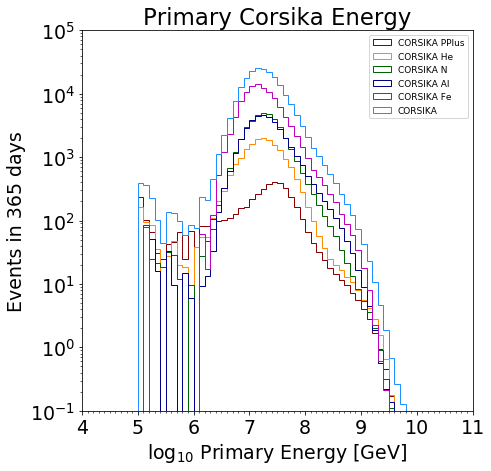

In [37]:
plt.figure(figsize=(7,7))

plt.hist(np.log10(prim_e_corsika[CUT_PPlus]),bins=np.arange(4,12,0.1),log=True,histtype='step',lw=1,label='CORSIKA PPlus',weights=weight_corsika[CUT_PPlus],bottom=10**(-6),color='darkred')
plt.hist(np.log10(prim_e_corsika[CUT_He]),bins=np.arange(4,12,0.1),log=True,histtype='step',lw=1,label='CORSIKA He',weights=weight_corsika[CUT_He],bottom=10**(-6),color='darkorange')
plt.hist(np.log10(prim_e_corsika[CUT_N]),bins=np.arange(4,12,0.1),log=True,histtype='step',lw=1,label='CORSIKA N',weights=weight_corsika[CUT_N],bottom=10**(-6),color='darkgreen')
plt.hist(np.log10(prim_e_corsika[CUT_Al]),bins=np.arange(4,12,0.1),log=True,histtype='step',lw=1,label='CORSIKA Al',weights=weight_corsika[CUT_Al],bottom=10**(-6),color='darkblue')
plt.hist(np.log10(prim_e_corsika[CUT_Fe]),bins=np.arange(4,12,0.1),log=True,histtype='step',lw=1,label='CORSIKA Fe',weights=weight_corsika[CUT_Fe],bottom=10**(-6),color='m')
plt.hist(np.log10(prim_e_corsika),bins=np.arange(4,12,0.1),log=True,histtype='step',lw=1,label='CORSIKA',weights=weight_corsika,bottom=10**(-6),color='dodgerblue')

plt.xlim(4,11)
plt.ylim(10**(-1),10**5)
plt.legend(prop={'size': 9})
plt.xlabel(r'$\log_{10}$ Primary Energy [GeV]')
plt.ylabel('Events in 365 days')
plt.title('Primary Corsika Energy')
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))

plt.savefig(fig_dir+'hist1d_primary_corsika_energy.png',bbox_inches='tight',dpi=300)
plt.savefig(fig_dir+'hist1d_primary_corsika_energy.pdf',bbox_inches='tight')


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


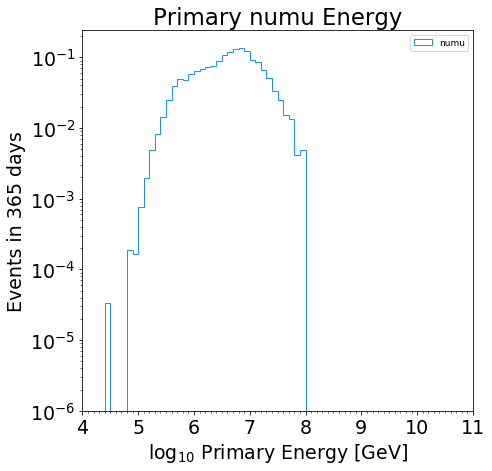

In [43]:
plt.figure(figsize=(7,7))
plt.hist(np.log10(prim_e_numu),bins=np.arange(4,12,0.1),log=True,histtype='step',lw=1,label='numu',weights=weight_numu_astro,bottom=10**(-6),color='dodgerblue')

plt.xlim(4,11)
# plt.ylim(10**(-1),10**5)
plt.legend(prop={'size': 9})
plt.xlabel(r'$\log_{10}$ Primary Energy [GeV]')
plt.ylabel('Events in 365 days')
plt.title('Primary numu Energy')
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))

plt.savefig(fig_dir+'hist1d_primary_numu_energy.png',bbox_inches='tight',dpi=300)
plt.savefig(fig_dir+'hist1d_primary_numu_energy.pdf',bbox_inches='tight')


# CORSIKA vs NUMU

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


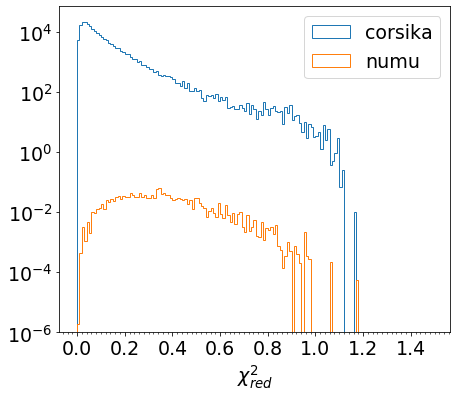

In [52]:
chi2_red_cut = 0.3
pom_cut = 0.8

plt.figure(figsize=(7,6))
plt.hist(chi2_red_corsika,bins=np.arange(0,1.5,0.01),weights=weight_corsika,histtype='step',log=True,label='corsika',bottom=10**(-6))
plt.hist(chi2_red_numu,bins=np.arange(0,1.5,0.01),weights=weight_numu_astro,histtype='step',log=True,label='numu',bottom=10**(-6))
# plt.axvline(chi2_red_cut,label=r'$\chi^2_{red}=$'+str(chi2_red_cut),color='b')
plt.legend()
plt.xlabel(r'$\chi^2_{red}$')
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
plt.savefig(fig_dir + 'hist1d_corsika_numu_chi2_red.png',dpi=600)


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


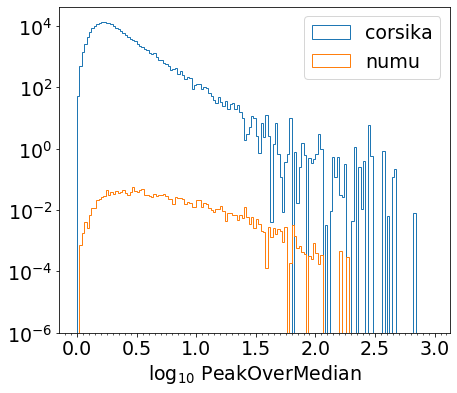

In [63]:
plt.figure(figsize=(7,6))
plt.hist(np.log10(PeakOverMedian_corsika),bins=np.arange(0,3.0,0.02),weights=weight_corsika,histtype='step',log=True,label='corsika',bottom=10**(-6))
plt.hist(np.log10(PeakOverMedian_numu),bins=np.arange(0,3.0,0.02),weights=weight_numu_astro,histtype='step',log=True,label='numu',bottom=10**(-6))
# plt.axvline(pom_cut,label=r'$logPeakOverMedian=$'+str(pom_cut),color='g')
plt.legend(loc='upper right')
plt.xlabel('$\log_{10}$ PeakOverMedian')
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.05))

plt.savefig(fig_dir + 'hist1d_corsika_numu_peakovermedian.png',dpi=300)
plt.show()

# stoch variable

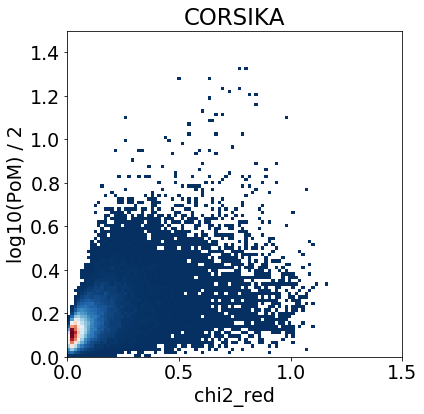

In [71]:
my_cmap = plt.cm.get_cmap('RdBu_r')
my_cmap.set_under('w')

plt.figure(figsize=(6,6))
plt.hist2d(chi2_red_corsika,np.log10(PeakOverMedian_corsika)/2,weights=weight_corsika,bins=100,range=[[0,1.5],[0,1.5]],cmap=my_cmap,vmin=1e-2)
plt.title('CORSIKA')
plt.xlabel('chi2_red')
plt.ylabel('log10(PoM) / 2')
plt.xlim(0,1.5)
plt.ylim(0,1.5)
plt.savefig(fig_dir + 'hist2d_chi2_pom.png',dpi=300)
plt.show()

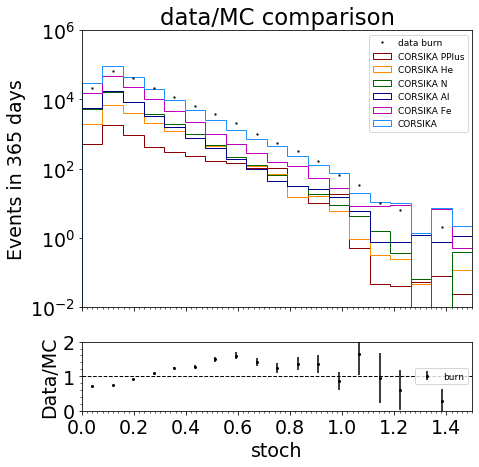

In [72]:
# stoch 

plt.figure(figsize=(7,7))

gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax1 = plt.subplot(gs[0])

# h_a,b_a,p_a = plt.hist(stoch_corsika,bins=np.arange(0,1.5,0.02),log=True,histtype='step',lw=1,label='CORSIKA adjusted',weights=weight_corsika_adjusted,bottom=10**(-6),color='red')

plt.hist(stoch_corsika[CUT_PPlus],bins=np.linspace(0,1.5,20),log=True,histtype='step',lw=1,label='CORSIKA PPlus',weights=weight_corsika[CUT_PPlus],bottom=10**(-6),color='darkred')
plt.hist(stoch_corsika[CUT_He],bins=np.linspace(0,1.5,20),log=True,histtype='step',lw=1,label='CORSIKA He',weights=weight_corsika[CUT_He],bottom=10**(-6),color='darkorange')
plt.hist(stoch_corsika[CUT_N],bins=np.linspace(0,1.5,20),log=True,histtype='step',lw=1,label='CORSIKA N',weights=weight_corsika[CUT_N],bottom=10**(-6),color='darkgreen')
plt.hist(stoch_corsika[CUT_Al],bins=np.linspace(0,1.5,20),log=True,histtype='step',lw=1,label='CORSIKA Al',weights=weight_corsika[CUT_Al],bottom=10**(-6),color='darkblue')
plt.hist(stoch_corsika[CUT_Fe],bins=np.linspace(0,1.5,20),log=True,histtype='step',lw=1,label='CORSIKA Fe',weights=weight_corsika[CUT_Fe],bottom=10**(-6),color='m')
h,b,p = plt.hist(stoch_corsika,bins=np.linspace(0,1.5,20),log=True,histtype='step',lw=1,label='CORSIKA',weights=weight_corsika,bottom=10**(-6),color='dodgerblue')

hh,bb = np.histogram(stoch_data_burn,bins=np.linspace(0,1.5,20),weights = weight_data_burn)
plt.plot((bb[1:]+bb[:-1])/2,hh,'.',ms=3,alpha=0.7,label='data burn',color='black')

plt.ylabel('Events in 365 days')
plt.xlim(0,1.5)
plt.ylim(10**(-2),10**6)
plt.legend(loc='best',prop={'size': 9})
plt.title('data/MC comparison')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
ax1.tick_params(labelbottom=False)    

ax2 = plt.subplot(gs[1])

err_w = np.sqrt(sumw2(h,b,weight_corsika,stoch_corsika))
err_ww = np.sqrt(sumw2(hh,bb,weight_data_burn,stoch_data_burn))

h = h[hh > 0.]
bb = ((bb[1:]+bb[:-1])/2)[hh > 0.]
err_w = err_w[hh>0.]
err_ww = err_ww[hh>0.]
hh = hh[hh > 0.]
yerr = np.sqrt(err_ww**2/h**2 + hh**2/h**4*err_w**2)
plt.errorbar(bb, hh/h, yerr = yerr, fmt='.',ms=4,color='black',label='burn')

plt.axhline(1,ls='--',lw=1,color='black')

plt.xlabel('stoch')
plt.ylabel('Data/MC')
plt.legend(loc='right',prop={'size': 9})
plt.xlim(0,1.5)
plt.ylim(0,2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(1.))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))

plt.savefig(fig_dir+'hist1d_stoch_data_MC.png',bbox_inches='tight',dpi=300)
plt.savefig(fig_dir+'hist1d_stoch_data_MC.pdf',bbox_inches='tight')

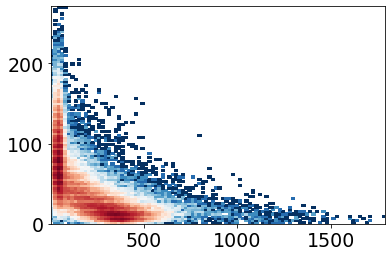

In [82]:
plt.hist2d(closest_d_data_burn,Npulse_in_window_data_burn,bins=100,cmap=my_cmap,vmin=1,norm=matplotlib.colors.LogNorm())
plt.show()

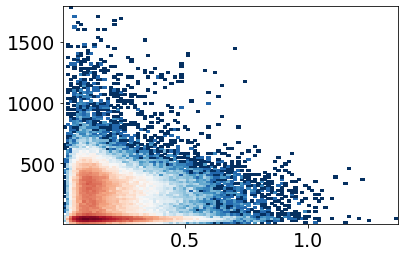

In [83]:
plt.hist2d(stoch_data_burn,closest_d_data_burn,bins=100,cmap=my_cmap,vmin=1,norm=matplotlib.colors.LogNorm())
plt.show()

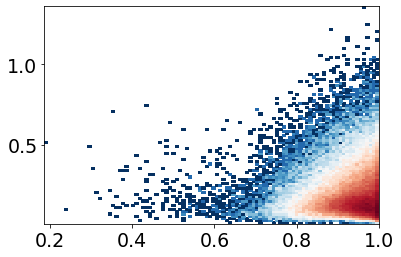

In [86]:
plt.hist2d(np.cos(zenith_data_burn),stoch_data_burn,bins=100,cmap=my_cmap,vmin=1,norm=matplotlib.colors.LogNorm())
plt.show() 